In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Loading Data

In [51]:
df = pd.read_csv('AEP_hourly.csv')
df.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


In [52]:
df.set_index('Datetime', inplace=True)
df.index = pd.to_datetime(df.index) 
df.head()

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 121273 entries, 2004-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   AEP_MW  121273 non-null  float64
dtypes: float64(1)
memory usage: 1.9 MB


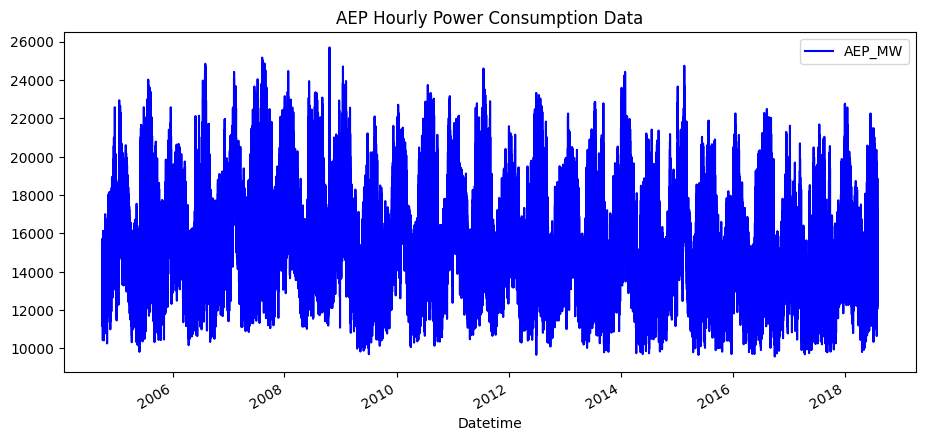

In [54]:
df.plot(figsize=(11, 5), color='b',
        title='AEP Hourly Power Consumption Data')
plt.show()

## Splitting Data

In [55]:
df_train = df.loc[df.index < '2015-01-01']
df_test = df.loc[df.index >= '2015-01-01']

df_train.shape, df_test.shape

((89833, 1), (31440, 1))

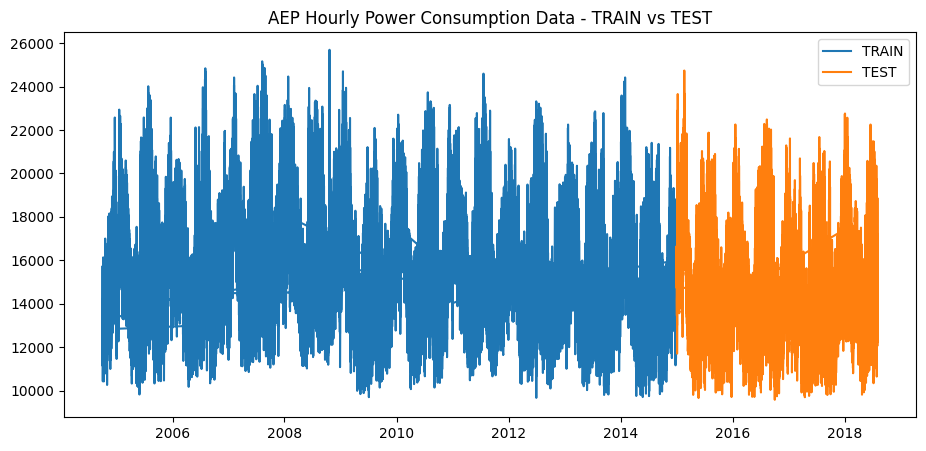

In [56]:
plt.subplots(figsize=(11, 5))
plt.plot(df_train['AEP_MW'])
plt.plot(df_test['AEP_MW'])
plt.title('AEP Hourly Power Consumption Data - TRAIN vs TEST')
plt.legend(['TRAIN','TEST'])
plt.show()

<Axes: xlabel='Datetime'>

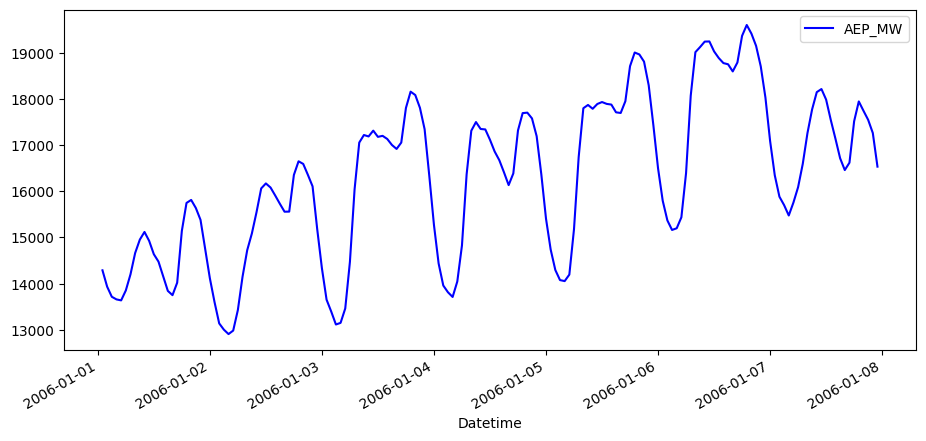

In [57]:
#A week of data
df.loc[(df.index > '2006-01-01') & (df.index < '2006-01-08')].plot(figsize=(11, 5), color='b')

## Feature Engineering  

In [58]:
def createFeatures(df):
  df = df.copy()
  df['day of week'] = df.index.dayofweek
  df['hour'] = df.index.hour
  df['month'] = df.index.month  
  df['quarter'] = df.index.quarter
  df['year'] = df.index.year
  df['day of year'] = df.index.dayofyear
  return df

df = createFeatures(df)
df.head()

,AEP_MW,day of week,hour,month,quarter,year,day of year
Datetime,,,,,,,
2004-12-31 01:00:00,13478.0,4,1,12,4,2004,366
2004-12-31 02:00:00,12865.0,4,2,12,4,2004,366
2004-12-31 03:00:00,12577.0,4,3,12,4,2004,366
2004-12-31 04:00:00,12517.0,4,4,12,4,2004,366
2004-12-31 05:00:00,12670.0,4,5,12,4,2004,366


## EDA

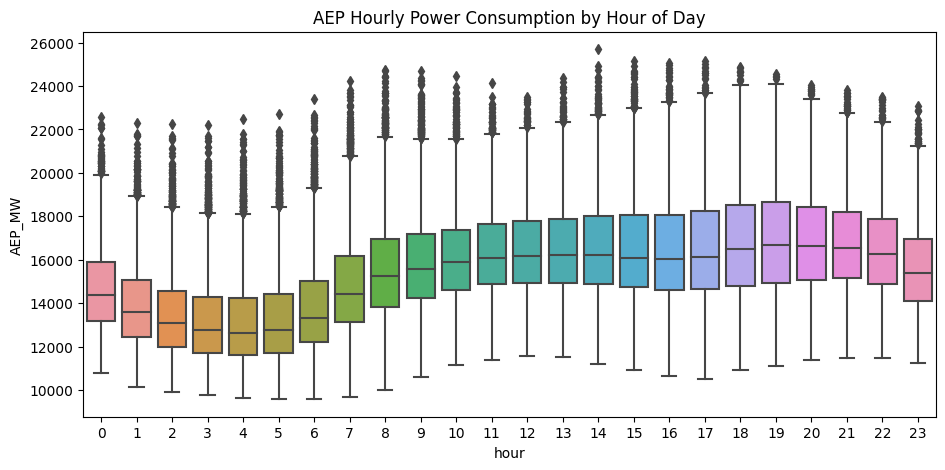

In [59]:
plt.figure(figsize=(11, 5))
sns.boxplot(data=df, x='hour', y='AEP_MW')
plt.title('AEP Hourly Power Consumption by Hour of Day')
plt.show()

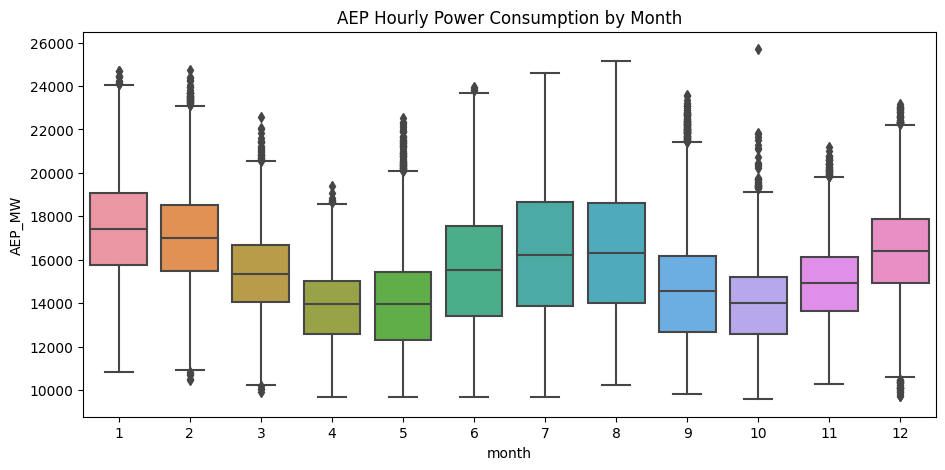

In [60]:
plt.figure(figsize=(11, 5))
sns.boxplot(data=df, x='month', y='AEP_MW')
plt.title('AEP Hourly Power Consumption by Month')
plt.show()

## Building Model

In [61]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [62]:
df_train = createFeatures(df_train) 
df_test = createFeatures(df_test)

X_train = df_train.drop(columns=['AEP_MW'])
y_train = df_train['AEP_MW']

X_test = df_test.drop(columns=['AEP_MW'])
y_test = df_test['AEP_MW']

In [63]:
model = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50, learning_rate=0.01)
model.fit(X_train, y_train,eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)

[0]	validation_0-rmse:2557.05852	validation_1-rmse:2669.66874
[100]	validation_0-rmse:1667.99304	validation_1-rmse:1906.43321
[200]	validation_0-rmse:1388.41609	validation_1-rmse:1728.03964
[300]	validation_0-rmse:1260.06288	validation_1-rmse:1670.93868
[400]	validation_0-rmse:1170.54347	validation_1-rmse:1651.83339
[500]	validation_0-rmse:1113.48343	validation_1-rmse:1644.49126
[545]	validation_0-rmse:1091.20163	validation_1-rmse:1647.88201


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Feature Importance

In [64]:
df_fi = pd.DataFrame(data=model.feature_importances_, index=model.feature_names_in_, columns=['feature importance'])
df_fi.sort_values(by='feature importance', ascending=False, inplace=True)
df_fi

,feature importance
hour,0.451918
day of week,0.190400
day of year,0.151228
month,0.145771
year,0.060682
quarter,0.000000


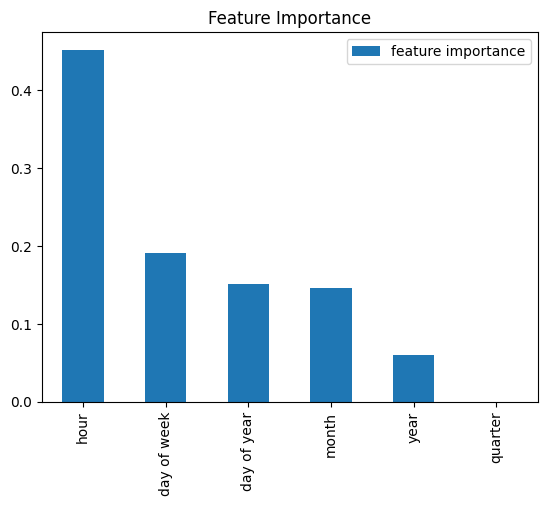

In [65]:
df_fi.plot(kind='bar')
plt.title('Feature Importance')
plt.show()

## Predction on Test Data

In [66]:
df_test['AEP_MW_Prediction'] = model.predict(X_test)

In [67]:
df_test

,AEP_MW,day of week,hour,month,quarter,year,day of year,AEP_MW_Prediction
Datetime,,,,,,,,
2015-01-01 00:00:00,16375.0,3,0,1,1,2015,1,16409.544922
2015-12-31 01:00:00,12415.0,3,1,12,4,2015,365,14913.538086
2015-12-31 02:00:00,12087.0,3,2,12,4,2015,365,14701.646484
2015-12-31 03:00:00,12010.0,3,3,12,4,2015,365,14601.142578
2015-12-31 04:00:00,11972.0,3,4,12,4,2015,365,14601.142578
...,...,...,...,...,...,...,...,...
2018-01-01 20:00:00,21089.0,0,20,1,1,2018,1,18657.703125
2018-01-01 21:00:00,20999.0,0,21,1,1,2018,1,18657.703125
2018-01-01 22:00:00,20820.0,0,22,1,1,2018,1,18711.419922


In [68]:
df = df.merge(df_test[['AEP_MW_Prediction']], left_index=True, right_index=True, how='left')
df.head()

,AEP_MW,day of week,hour,month,quarter,year,day of year,AEP_MW_Prediction
Datetime,,,,,,,,
2004-10-01 01:00:00,12379.0,4,1,10,4,2004,275,NaN
2004-10-01 02:00:00,11935.0,4,2,10,4,2004,275,NaN
2004-10-01 03:00:00,11692.0,4,3,10,4,2004,275,NaN
2004-10-01 04:00:00,11597.0,4,4,10,4,2004,275,NaN
2004-10-01 05:00:00,11681.0,4,5,10,4,2004,275,NaN


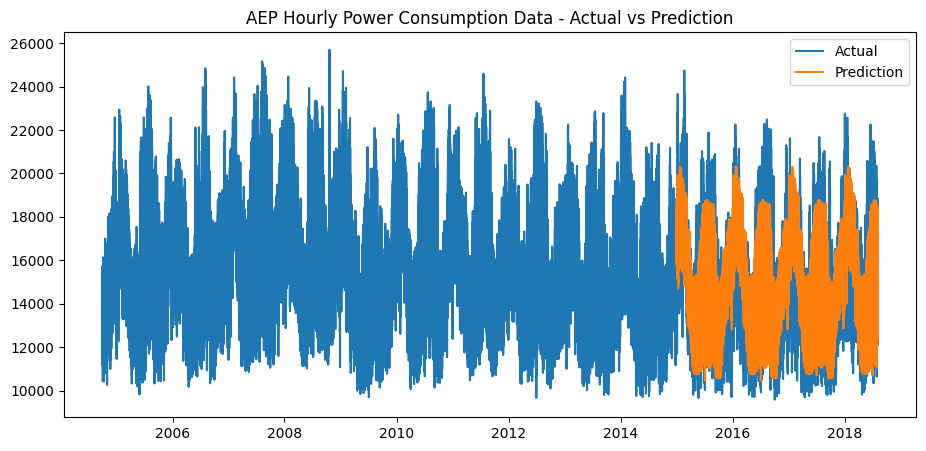

In [70]:
plt.subplots(figsize=(11, 5))
plt.plot(df['AEP_MW'])
plt.plot(df['AEP_MW_Prediction'])
plt.title('AEP Hourly Power Consumption Data - Actual vs Prediction')
plt.legend(['Actual','Prediction'])
plt.show()

## Evaluation

In [73]:
print('MAE:', mean_absolute_error(df_test['AEP_MW'], df_test['AEP_MW_Prediction']))
print('RMSE:', np.sqrt(mean_squared_error(df_test['AEP_MW'], df_test['AEP_MW_Prediction'])))

MAE: 1295.767473107258
RMSE: 1644.3873400386153
